In [69]:
# !pip install coclust
# !curl https://raw.githubusercontent.com/aciobanusebi/deep-clustering/main/metric_functions.py -o metric_functions.py
# !curl https://raw.githubusercontent.com/aciobanusebi/deep-clustering/main/module_functions.py -o module_functions.py
# !curl https://raw.githubusercontent.com/aciobanusebi/deep-clustering/main/get_datasets.py -o get_datasets.py
# !curl https://raw.githubusercontent.com/aciobanusebi/deep-clustering/main/usps.py -o usps.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   716  100   716    0     0    716      0  0:00:01 --:--:--  0:00:01  3828
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 16707  100 16707    0     0  16707      0  0:00:01 --:--:--  0:00:01 71397


In [1]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import matplotlib.pyplot as plt
import numpy as np

from metric_functions import *
from module_functions import *
from get_datasets import *

dim_pca = None # None or a number; cannot use CNN with this "on"

n_runs = 1
epochs = 10

read_model_from_file = False
l2_reg_on_nn = False
data_name = "20news"
original_data_name = data_name
if dim_pca is not None:
    data_name+="PCA"
ae_type = "mlp" #@param ["mlp", "cnn"]
dist_type = "normal" #@param ["normal", "cauchy"]
encoder_depth = "0" #@param [0, 1, 2]
encoder_depth = int(encoder_depth)
nn_depth = "2" #@param [0, 1, 2, 3]
nn_depth = int(nn_depth)
lambdaa = 50.0 # [0,inf); for std
cl_loss_type = "km" # "km", "gmm"
id = f"{cl_loss_type}_{ae_type}_{dist_type}_{encoder_depth}_{nn_depth}_{int(lambdaa)}"
random_id = f"random_{id}"
print(id)
general_directory = "."

var_features = True # True/False
var_locs = False # True/False
reg_logits = False # True/False
kl_loss = False # True/False
logits_trainable = False # True/False
locs_trainable = False # True/False
covs_trainable = False # True/False
loc_inner_value = 1.0 # mu initialization is multiplied by this value; if set to None, then we use uniform random init in [0,1]; we used this random init when starting the project
# number_of_dist = 10
if original_data_name == "mnist":
    samples, real_labels = get_data_mnist()
elif original_data_name == "20news":
    samples, real_labels = get_data_20news()
elif original_data_name == "usps":
    samples, real_labels = get_data_usps()
    
number_of_dist = len(np.unique(real_labels))
print(number_of_dist)

import math
if ae_type == "cnn":
    samples = samples.reshape((-1,
                             int(math.sqrt(samples.shape[1])),
                             int(math.sqrt(samples.shape[1])),
                             1))
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024
prob_d = number_of_dist
last_layer_decoder_activation = 'sigmoid'
last_layer_nn_activation = 'linear'
default_activation = 'tanh'
plot_at_each_iteration = True
if ae_type == "mlp":
  ds_encoder = [128,64] # [64,128]/[64] for "cnn"; [increasing] for "mlp"
else:
  ds_encoder = [64,128]
ds_nn = [32,prob_d]
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # learning_rate=0.00001; era 0.001

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

C:\Users\Sebi\anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


km_mlp_normal_0_2_50
20


In [2]:
# mnist = tf.keras.datasets.mnist
# (x_train, y_train),(x_test, y_test) = mnist.load_data()

# x_train = np.concatenate((x_train,x_test))
# y_train = np.concatenate((y_train,y_test))

# real_labels = y_train

# indices = np.isin(y_train,range(number_of_dist))
# x_train = x_train[indices]
# y_train = y_train[indices]

# if ae_type == "mlp":
#   samples = (x_train.reshape((x_train.shape[0],-1))/255.).astype(np.float32)
# else:
#   samples = x_train
#   samples = samples.astype('float32') / 255.
#   samples = samples[...,np.newaxis]

In [3]:
if dim_pca is not None:
    import numpy as np
    from sklearn.decomposition import PCA
    X = samples
    pca = PCA(n_components=dim_pca)
    samples = pca.fit_transform(X)

0


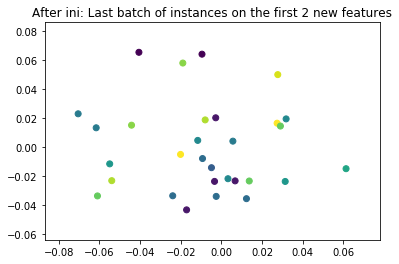

0
[<tf.Variable 'loc0:0' shape=(20,) dtype=float32, numpy=
array([ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc1:0' shape=(20,) dtype=float32, numpy=
array([-1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc2:0' shape=(20,) dtype=float32, numpy=
array([-1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc3:0' shape=(20,) dtype=float32, numpy=
array([-1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc4:0' shape=(20,) dtype=float32, numpy=
array([-1., -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc5:0' shape=(20,) dtype=float32, numpy=
a

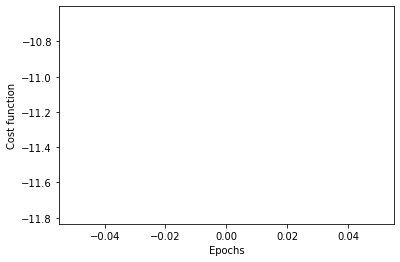

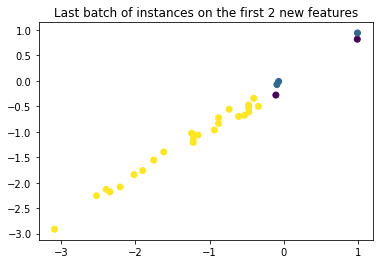

1
[<tf.Variable 'loc0:0' shape=(20,) dtype=float32, numpy=
array([ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc1:0' shape=(20,) dtype=float32, numpy=
array([-1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc2:0' shape=(20,) dtype=float32, numpy=
array([-1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc3:0' shape=(20,) dtype=float32, numpy=
array([-1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc4:0' shape=(20,) dtype=float32, numpy=
array([-1., -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc5:0' shape=(20,) dtype=float32, numpy=
a

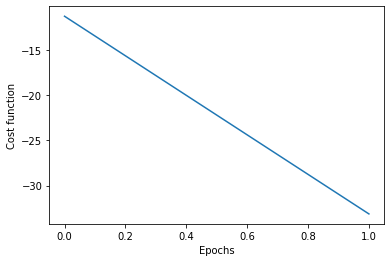

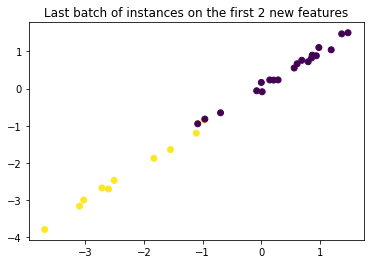

2
[<tf.Variable 'loc0:0' shape=(20,) dtype=float32, numpy=
array([ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc1:0' shape=(20,) dtype=float32, numpy=
array([-1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc2:0' shape=(20,) dtype=float32, numpy=
array([-1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc3:0' shape=(20,) dtype=float32, numpy=
array([-1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc4:0' shape=(20,) dtype=float32, numpy=
array([-1., -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc5:0' shape=(20,) dtype=float32, numpy=
a

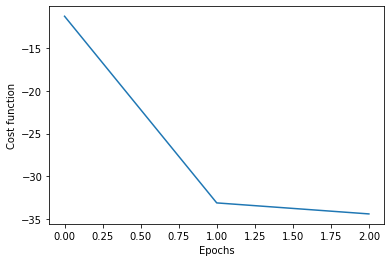

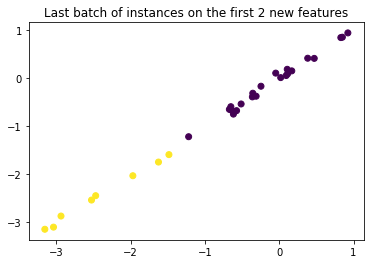

3
[<tf.Variable 'loc0:0' shape=(20,) dtype=float32, numpy=
array([ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc1:0' shape=(20,) dtype=float32, numpy=
array([-1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc2:0' shape=(20,) dtype=float32, numpy=
array([-1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc3:0' shape=(20,) dtype=float32, numpy=
array([-1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc4:0' shape=(20,) dtype=float32, numpy=
array([-1., -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc5:0' shape=(20,) dtype=float32, numpy=
a

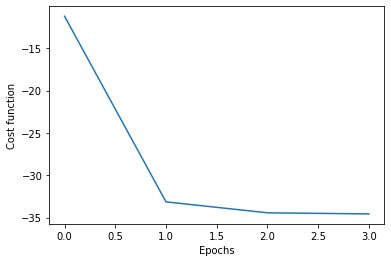

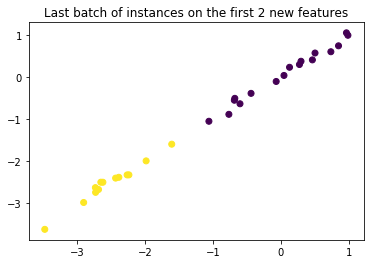

4
[<tf.Variable 'loc0:0' shape=(20,) dtype=float32, numpy=
array([ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc1:0' shape=(20,) dtype=float32, numpy=
array([-1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc2:0' shape=(20,) dtype=float32, numpy=
array([-1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc3:0' shape=(20,) dtype=float32, numpy=
array([-1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc4:0' shape=(20,) dtype=float32, numpy=
array([-1., -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc5:0' shape=(20,) dtype=float32, numpy=
a

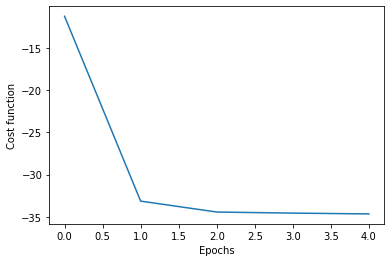

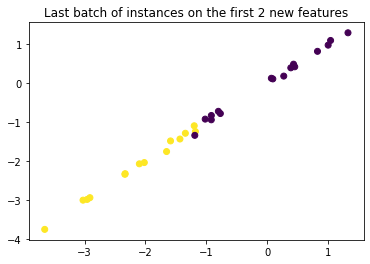

5
[<tf.Variable 'loc0:0' shape=(20,) dtype=float32, numpy=
array([ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc1:0' shape=(20,) dtype=float32, numpy=
array([-1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc2:0' shape=(20,) dtype=float32, numpy=
array([-1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc3:0' shape=(20,) dtype=float32, numpy=
array([-1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc4:0' shape=(20,) dtype=float32, numpy=
array([-1., -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc5:0' shape=(20,) dtype=float32, numpy=
a

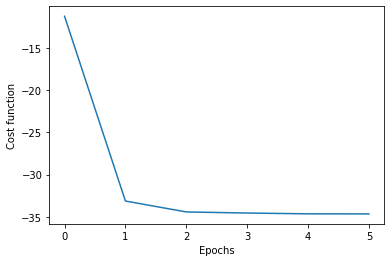

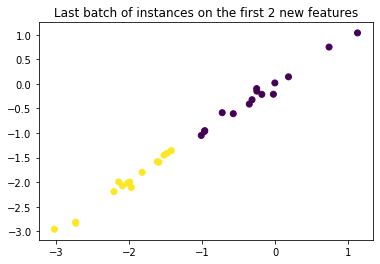

6


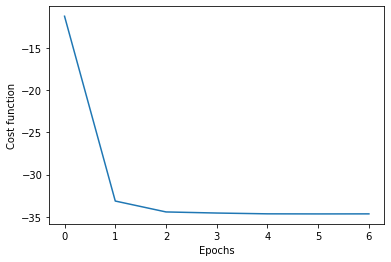

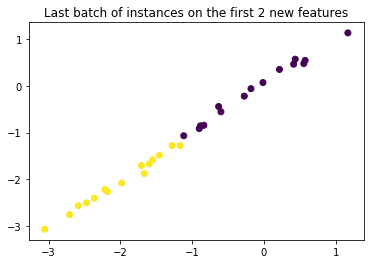

7
[<tf.Variable 'loc0:0' shape=(20,) dtype=float32, numpy=
array([ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc1:0' shape=(20,) dtype=float32, numpy=
array([-1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc2:0' shape=(20,) dtype=float32, numpy=
array([-1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc3:0' shape=(20,) dtype=float32, numpy=
array([-1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc4:0' shape=(20,) dtype=float32, numpy=
array([-1., -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>, <tf.Variable 'loc5:0' shape=(20,) dtype=float32, numpy=
a

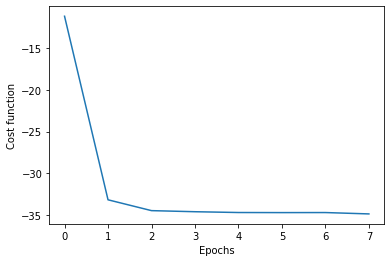

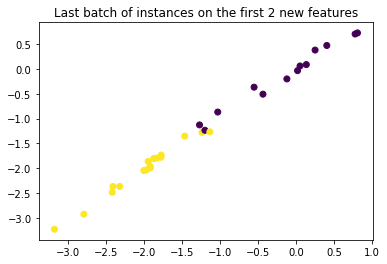

8


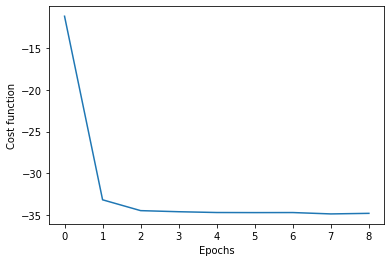

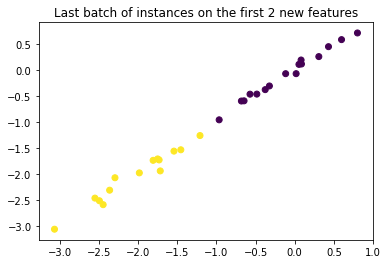

9


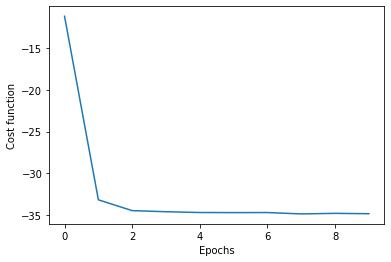

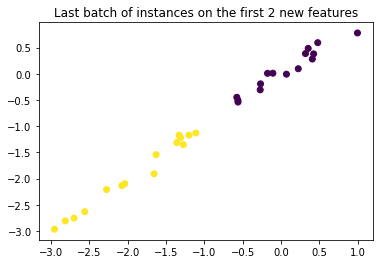

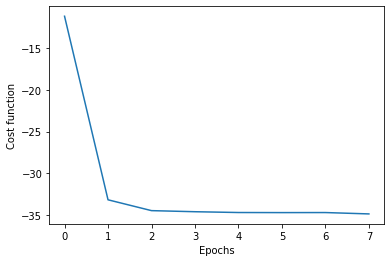

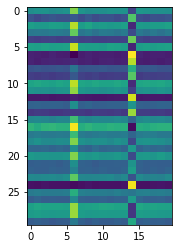

()


In [4]:
random_mean_losses = []
random_clusterings = []
best_mean_losses = []
clusterings = []
for run in range(n_runs):
    print(run)
    random_mean_loss,random_clustering, best_mean_loss,clustering = main(read_model_from_file,
        run,
        samples,
        ae_type,
        dist_type,
        encoder_depth,
        nn_depth,
        id,
        random_id,
        data_name,
        general_directory,
        lambdaa,
        cl_loss_type,
        var_features,
        var_locs,
        reg_logits,
        kl_loss,
        logits_trainable,
        locs_trainable,
        covs_trainable,
        loc_inner_value,
        number_of_dist,
        BATCH_SIZE,
        SHUFFLE_BUFFER_SIZE,
        prob_d,
        last_layer_decoder_activation,
        last_layer_nn_activation,
        default_activation,
        plot_at_each_iteration,
        ds_encoder,
        ds_nn,
        optimizer,
        epochs,
        l2_reg_on_nn)
    
    random_mean_losses.append(random_mean_loss)
    random_clusterings.append(random_clustering)
    best_mean_losses.append(best_mean_loss)
    clusterings.append(clustering)

In [5]:
random_mean_losses,random_clusterings

([18.144701],
 [[13,
   8,
   10,
   19,
   3,
   17,
   2,
   19,
   7,
   2,
   8,
   9,
   7,
   15,
   14,
   10,
   14,
   2,
   17,
   2,
   17,
   14,
   8,
   6,
   15,
   16,
   10,
   8,
   10,
   9,
   2,
   17,
   8,
   7,
   8,
   15,
   14,
   2,
   14,
   9,
   10,
   9,
   8,
   19,
   14,
   2,
   8,
   19,
   14,
   8,
   8,
   17,
   11,
   13,
   12,
   16,
   8,
   16,
   14,
   10,
   16,
   1,
   18,
   12,
   2,
   1,
   17,
   1,
   0,
   14,
   15,
   3,
   13,
   8,
   8,
   14,
   8,
   17,
   15,
   10,
   8,
   10,
   2,
   14,
   12,
   8,
   7,
   9,
   2,
   9,
   15,
   14,
   16,
   4,
   7,
   16,
   12,
   10,
   12,
   14,
   14,
   18,
   8,
   15,
   11,
   10,
   11,
   18,
   16,
   17,
   14,
   15,
   12,
   14,
   15,
   16,
   8,
   7,
   10,
   19,
   19,
   15,
   0,
   2,
   14,
   14,
   12,
   8,
   8,
   18,
   9,
   9,
   19,
   9,
   1,
   6,
   8,
   10,
   16,
   14,
   16,
   7,
   9,
   18,
   17,
   7,
   2,
   14,
   2,
   14,

In [6]:
best_mean_losses, clusterings

([-34.83008],
 [[14,
   6,
   14,
   6,
   6,
   6,
   6,
   14,
   14,
   14,
   14,
   6,
   14,
   6,
   6,
   14,
   6,
   14,
   14,
   14,
   14,
   6,
   6,
   14,
   14,
   6,
   14,
   6,
   6,
   14,
   6,
   14,
   6,
   14,
   6,
   6,
   6,
   14,
   14,
   6,
   14,
   6,
   14,
   6,
   6,
   6,
   6,
   6,
   14,
   6,
   6,
   14,
   6,
   6,
   14,
   14,
   14,
   6,
   14,
   14,
   14,
   14,
   6,
   6,
   14,
   14,
   14,
   14,
   6,
   6,
   6,
   6,
   6,
   6,
   14,
   14,
   14,
   6,
   6,
   14,
   6,
   14,
   6,
   6,
   6,
   14,
   14,
   14,
   14,
   14,
   14,
   14,
   14,
   6,
   14,
   6,
   6,
   6,
   14,
   6,
   14,
   6,
   6,
   14,
   6,
   6,
   14,
   14,
   6,
   6,
   6,
   14,
   14,
   6,
   14,
   14,
   6,
   14,
   14,
   6,
   6,
   14,
   6,
   14,
   14,
   6,
   6,
   6,
   6,
   6,
   6,
   14,
   14,
   14,
   6,
   6,
   6,
   14,
   6,
   6,
   14,
   6,
   14,
   6,
   14,
   14,
   6,
   6,
   6,
   6,
   6,
   6,
   

In [7]:
import numpy as np
random_index = np.argmin(random_mean_losses)
final_random_clustering = random_clusterings[random_index]
final_random_metrics = [purity_score(real_labels,final_random_clustering),
    adjusted_rand_score(real_labels,final_random_clustering),
    normalized_mutual_info_score(real_labels,final_random_clustering),
    accuracy(real_labels,final_random_clustering)]
random_path = os.path.join(general_directory,data_name,random_id,"final_random_metrics.txt")
f = open(random_path, "w")
f.writelines([str(x)+"\n" for x in final_random_metrics])
f.close()

import numpy as np
index = np.argmin(best_mean_losses)
final_clustering = clusterings[index]

final_metrics = [purity_score(real_labels,final_clustering),
    adjusted_rand_score(real_labels,final_clustering),
    normalized_mutual_info_score(real_labels,final_clustering),
    accuracy(real_labels,final_clustering)]
path = os.path.join(general_directory,data_name,id,"final_metrics.txt")
f = open(path, "w")
f.writelines([str(x)+"\n" for x in final_metrics])
f.close()

C:\Users\Sebi\anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
C:\Users\Sebi\anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [8]:
random_mean_losses = []
random_clusterings = []
best_mean_losses = []
clusterings = []
for run in range(n_runs):
    print(run)
    random_mean_loss,random_clustering, best_mean_loss,clustering = main(True,
        run,
        samples,
        ae_type,
        dist_type,
        encoder_depth,
        nn_depth,
        id,
        random_id,
        data_name,
        general_directory,
        lambdaa,
        cl_loss_type,
        var_features,
        var_locs,
        reg_logits,
        kl_loss,
        logits_trainable,
        locs_trainable,
        covs_trainable,
        loc_inner_value,
        number_of_dist,
        BATCH_SIZE,
        SHUFFLE_BUFFER_SIZE,
        prob_d,
        last_layer_decoder_activation,
        last_layer_nn_activation,
        default_activation,
        plot_at_each_iteration,
        ds_encoder,
        ds_nn,
        optimizer,
        epochs,
        l2_reg_on_nn)
    
    random_mean_losses.append(random_mean_loss)
    random_clusterings.append(random_clustering)
    best_mean_losses.append(best_mean_loss)
    clusterings.append(clustering)

0


In [9]:
random_mean_losses,random_clusterings

([18.144701],
 [[13,
   8,
   10,
   19,
   3,
   17,
   2,
   19,
   7,
   2,
   8,
   9,
   7,
   15,
   14,
   10,
   14,
   2,
   17,
   2,
   17,
   14,
   8,
   6,
   15,
   16,
   10,
   8,
   10,
   9,
   2,
   17,
   8,
   7,
   8,
   15,
   14,
   2,
   14,
   9,
   10,
   9,
   8,
   19,
   14,
   2,
   8,
   19,
   14,
   8,
   8,
   17,
   11,
   13,
   12,
   16,
   8,
   16,
   14,
   10,
   16,
   1,
   18,
   12,
   2,
   1,
   17,
   1,
   0,
   14,
   15,
   3,
   13,
   8,
   8,
   14,
   8,
   17,
   15,
   10,
   8,
   10,
   2,
   14,
   12,
   8,
   7,
   9,
   2,
   9,
   15,
   14,
   16,
   4,
   7,
   16,
   12,
   10,
   12,
   14,
   14,
   18,
   8,
   15,
   11,
   10,
   11,
   18,
   16,
   17,
   14,
   15,
   12,
   14,
   15,
   16,
   8,
   7,
   10,
   19,
   19,
   15,
   0,
   2,
   14,
   14,
   12,
   8,
   8,
   18,
   9,
   9,
   19,
   9,
   1,
   6,
   8,
   10,
   16,
   14,
   16,
   7,
   9,
   18,
   17,
   7,
   2,
   14,
   2,
   14,

In [10]:
best_mean_losses, clusterings

([-34.83008],
 [[14,
   6,
   14,
   6,
   6,
   6,
   6,
   14,
   14,
   14,
   14,
   6,
   14,
   6,
   6,
   14,
   6,
   14,
   14,
   14,
   14,
   6,
   6,
   14,
   14,
   6,
   14,
   6,
   6,
   14,
   6,
   14,
   6,
   14,
   6,
   6,
   6,
   14,
   14,
   6,
   14,
   6,
   14,
   6,
   6,
   6,
   6,
   6,
   14,
   6,
   6,
   14,
   6,
   6,
   14,
   14,
   14,
   6,
   14,
   14,
   14,
   14,
   6,
   6,
   14,
   14,
   14,
   14,
   6,
   6,
   6,
   6,
   6,
   6,
   14,
   14,
   14,
   6,
   6,
   14,
   6,
   14,
   6,
   6,
   6,
   14,
   14,
   14,
   14,
   14,
   14,
   14,
   14,
   6,
   14,
   6,
   6,
   6,
   14,
   6,
   14,
   6,
   6,
   14,
   6,
   6,
   14,
   14,
   6,
   6,
   6,
   14,
   14,
   6,
   14,
   14,
   6,
   14,
   14,
   6,
   6,
   14,
   6,
   14,
   14,
   6,
   6,
   6,
   6,
   6,
   6,
   14,
   14,
   14,
   6,
   6,
   6,
   14,
   6,
   6,
   14,
   6,
   14,
   6,
   14,
   14,
   6,
   6,
   6,
   6,
   6,
   6,
   